In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import pickle

sys.path.append("../scripts/")

from utils import Utils
from clean_data import DataCleaner
from plot import Plotter
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [2]:
utils = Utils()
plotter = Plotter
cleaner = DataCleaner()
plotter = Plotter()


In [3]:
# Load data
df = Utils().load_data("../data/Week1_challenge_data_source(CSV).csv")


In [4]:
df.shape

(150001, 55)

In [5]:
cleaned_df = cleaner.remove_whitespace_column(df)
cleaned_df = cleaner.convert_to_string(cleaned_df)
cleaned_df = cleaner.convert_to_datetime(cleaned_df)
cleaned_df = cleaner.remove_nan_categorical(cleaned_df)
cleaned_df = cleaner.fill_missing_values_numeric(cleaned_df, "median")

In [6]:
df.shape

(150001, 55)

In [7]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',


In [8]:
#Group by MSISDN
msisdn_group = df.groupby("msisdn/number")

In [9]:
sessions = msisdn_group.agg({'bearer_id': 'count'})
sessions_freq = sessions.rename(columns={'bearer_id': 'sessions'})
sessions_freq.sort_values(by='sessions', ascending=False)

,sessions
msisdn/number,
nan,1066
33626320676.0,18
33625779332.0,17
33614892860.0,17
33659725664.0,16
...,...
33660675684.0,1
33660674747.0,1
33660674252.0,1


In [10]:
# Session duration
session_durations = msisdn_group.agg({'dur._(ms)': 'sum'})
session_durations = session_durations.rename(columns={'dur._(ms)': 'duration(ms)'})
session_durations

,duration(ms)
msisdn/number,
3197020876596.0,877385.0
33601001722.0,116720.0
33601001754.0,181230.0
33601002511.0,134969.0
33601007832.0,49878.0
...,...
33789980299.0,210389.0
33789996170.0,8810.0
33789997247.0,140988.0


In [11]:
df['total_data'] = df['total_ul_(bytes)'] + df['total_dl_(bytes)']

In [12]:
# Session total traffic
session_traffic = msisdn_group.agg({'total_data': 'sum'})
session_traffic

,total_data
msisdn/number,
3197020876596.0,2.321240e+08
33601001722.0,8.786906e+08
33601001754.0,1.568596e+08
33601002511.0,5.959665e+08
33601007832.0,4.223207e+08
...,...
33789980299.0,1.094693e+09
33789996170.0,7.146416e+08
33789997247.0,4.803073e+08


In [13]:
# Aggregate User Engagement Metric
user_engagement = msisdn_group.agg({'total_data': 'sum', 'dur._(ms)': 'sum','bearer_id': 'count'})
user_engagement = user_engagement.rename(columns={'total_data': 'session_traffic(bytes)', 'dur._(ms)': 'session_duration(ms)', 'bearer_id': 'session_freq'})
# Sort the aggregate dataframe by engagement_metric
user_engagement.sort_values(by=['session_traffic(bytes)', 'session_freq', 'session_duration(ms)'], ascending=False, inplace=True)

### Top 10 customers per engagement metric

In [14]:
engagement_metric = user_engagement[['session_traffic(bytes)', 'session_freq', 'session_duration(ms)']]
user_engagement.head(10)

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
nan,5.312489e+11,72446396.0,1066
33614892860.0,8.846226e+09,9966898.0,17
33760536639.0,8.514774e+09,9279434.0,15
33625779332.0,8.499621e+09,18553754.0,17
33626320676.0,7.971167e+09,8791927.0,18
33675877202.0,7.891111e+09,4865947.0,15
33659725664.0,7.705863e+09,4035428.0,16
33666464084.0,7.308501e+09,4536757.0,11
33760413819.0,7.132371e+09,5321667.0,12


In [15]:
# Top 10 user per session frequency
top_users_session_freq = user_engagement.sort_values(by=['session_freq'], ascending=False, inplace=False)
top_users_session_freq.head(10)

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
nan,5.312489e+11,72446396.0,1066
33626320676.0,7.971167e+09,8791927.0,18
33625779332.0,8.499621e+09,18553754.0,17
33614892860.0,8.846226e+09,9966898.0,17
33659725664.0,7.705863e+09,4035428.0,16
33760536639.0,8.514774e+09,9279434.0,15
33675877202.0,7.891111e+09,4865947.0,15
33667163239.0,5.618394e+09,8744914.0,13
33786323068.0,5.622232e+09,4059652.0,12


In [16]:
# Top 10 user per session duration
top_users_session_duration = user_engagement.sort_values(by=['session_duration(ms)'], ascending=False, inplace=False)
top_users_session_duration.head(10)

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
nan,5.312489e+11,72446396.0,1066
33625779332.0,8.499621e+09,18553754.0,17
33614892860.0,8.846226e+09,9966898.0,17
33760536639.0,8.514774e+09,9279434.0,15
33626320676.0,7.971167e+09,8791927.0,18
33667163239.0,5.618394e+09,8744914.0,13
33662840755.0,4.000098e+09,6614270.0,9
33664693736.0,5.682007e+09,6288730.0,9
33603127838.0,4.976195e+09,6287761.0,12


In [17]:
# Top 10 user per session traffic
top_users_session_traffic = user_engagement.sort_values(by=['session_traffic(bytes)'], ascending=False, inplace=False)
top_users_session_traffic.head(10)

,session_traffic(bytes),session_duration(ms),session_freq
msisdn/number,,,
nan,5.312489e+11,72446396.0,1066
33614892860.0,8.846226e+09,9966898.0,17
33760536639.0,8.514774e+09,9279434.0,15
33625779332.0,8.499621e+09,18553754.0,17
33626320676.0,7.971167e+09,8791927.0,18
33675877202.0,7.891111e+09,4865947.0,15
33659725664.0,7.705863e+09,4035428.0,16
33666464084.0,7.308501e+09,4536757.0,11
33760413819.0,7.132371e+09,5321667.0,12


### Detect if outliers are present using boxplots

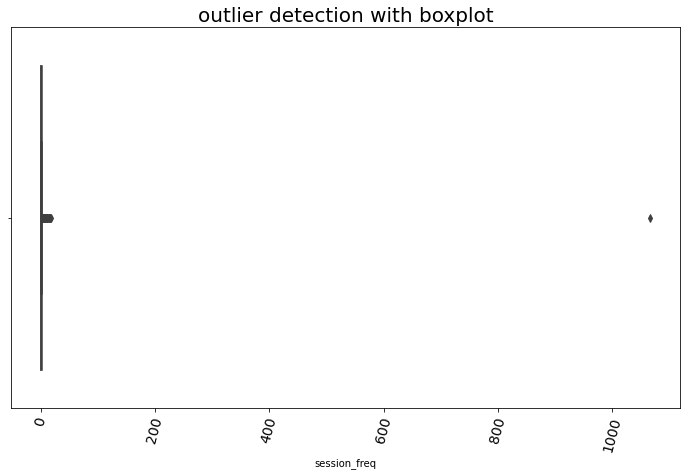

In [18]:
Plotter.plot_box(engagement_metric, 'session_freq', 'outlier detection with boxplot')

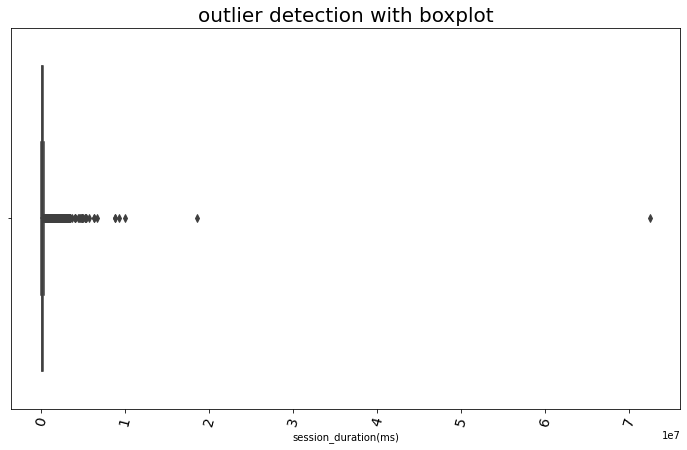

In [19]:
Plotter.plot_box(engagement_metric, 'session_duration(ms)', 'outlier detection with boxplot')

We can see from the box plot that there are outliers in the data and should be handled

In [20]:
cleaned_engagement_metric = cleaner.handle_outliers(engagement_metric, 'session_freq')
cleaned_engagement_metric = cleaner.handle_outliers(cleaned_engagement_metric, 'session_duration(ms)')
cleaned_engagement_metric = cleaner.handle_outliers(cleaned_engagement_metric, 'session_traffic(bytes)')
cleaned_engagement_metric



,session_traffic(bytes),session_freq,session_duration(ms)
msisdn/number,,,
nan,1.605760e+09,3.5,325034.0
33614892860.0,1.605760e+09,3.5,325034.0
33760536639.0,1.605760e+09,3.5,325034.0
33625779332.0,1.605760e+09,3.5,325034.0
33626320676.0,1.605760e+09,3.5,325034.0
...,...,...,...
33675475328.0,3.802236e+07,1.0,38371.0
33782507973.0,3.792924e+07,1.0,102689.0
33666684512.0,3.399962e+07,1.0,190320.0


In [21]:
engagement_metric['session_freq'].describe()

count    106857.000000
mean          1.403755
std           3.355032
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1066.000000
Name: session_freq, dtype: float64

From the above comparision we can see that the 

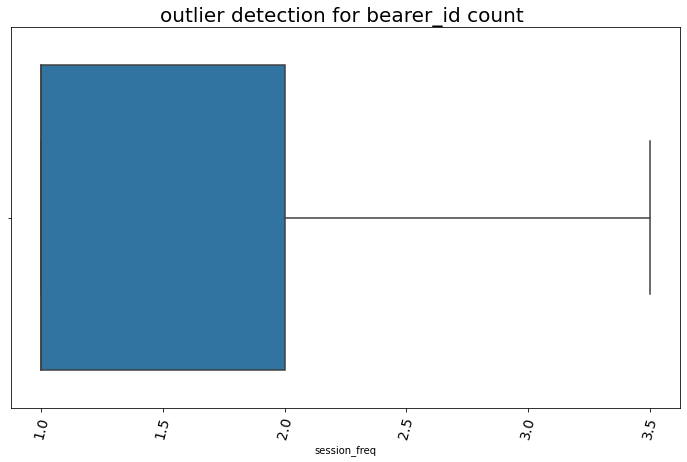

In [22]:
Plotter.plot_box(cleaned_engagement_metric, 'session_freq', 'outlier detection for bearer_id count ')


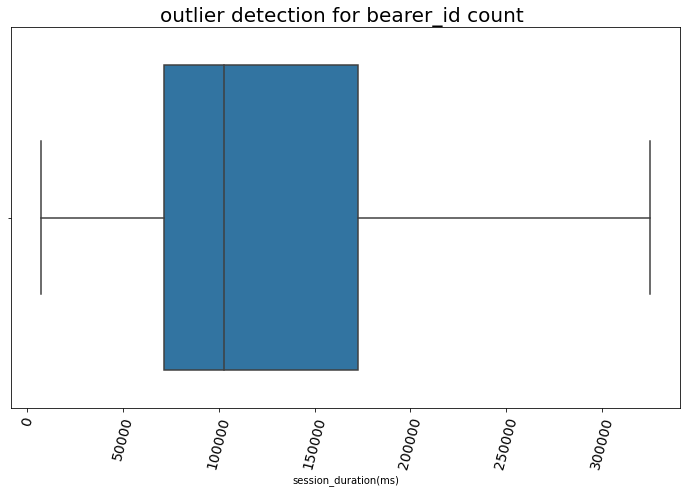

In [23]:
Plotter.plot_box(cleaned_engagement_metric, 'session_duration(ms)', 'outlier detection for bearer_id count ')


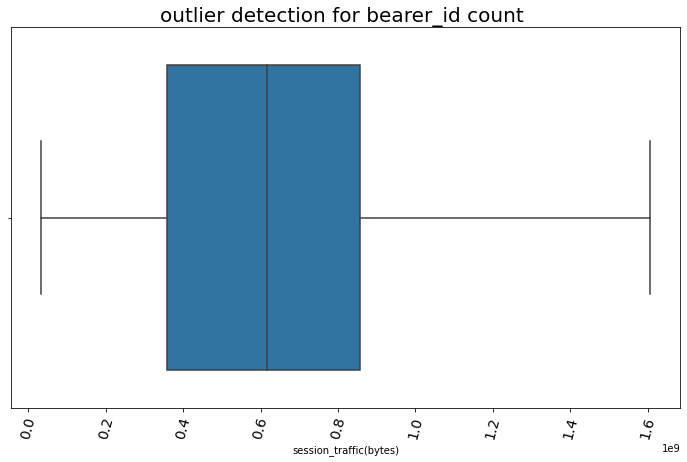

In [24]:
Plotter.plot_box(cleaned_engagement_metric, 'session_traffic(bytes)', 'outlier detection for bearer_id count ')


As shown in the above plots the outliers have been handled for each column

#### Customer clustering using K-means

In [25]:
# First normalize the data
normalized_engagement_metric = cleaner.normalizer(cleaned_engagement_metric)
normalized_engagement_metric


,session_traffic(bytes),session_freq,session_duration(ms)
0,1.000000,2.179653e-09,0.000202
1,1.000000,2.179653e-09,0.000202
2,1.000000,2.179653e-09,0.000202
3,1.000000,2.179653e-09,0.000202
4,1.000000,2.179653e-09,0.000202
...,...,...,...
106852,0.999999,2.630030e-08,0.001009
106853,0.999996,2.636479e-08,0.002707
106854,0.999984,2.941163e-08,0.005598
106855,0.999988,2.978296e-08,0.004950


In [26]:
kmeans= KMeans(
    init="k-means++",
    n_clusters= 3,
    n_init= 10,
    max_iter= 300,
    random_state=20  
)

In [27]:
model = kmeans.fit(normalized_engagement_metric)

In [28]:
with open("../models/user_engamenet_metric_clustering_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [29]:
cleaned_engagement_metric['cluster'] = model.predict(cleaned_engagement_metric)


In [30]:
cleaned_engagement_metric.head()

,session_traffic(bytes),session_freq,session_duration(ms),cluster
msisdn/number,,,,
nan,1.605760e+09,3.5,325034.0,0
33614892860.0,1.605760e+09,3.5,325034.0,0
33760536639.0,1.605760e+09,3.5,325034.0,0
33625779332.0,1.605760e+09,3.5,325034.0,0
33626320676.0,1.605760e+09,3.5,325034.0,0


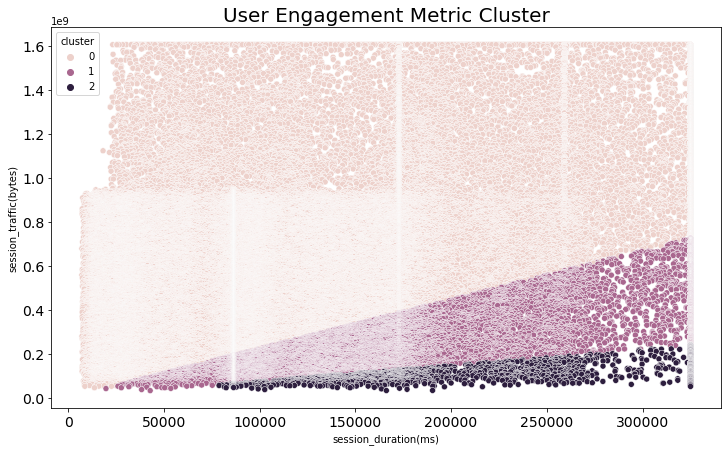

In [31]:
Plotter.plot_scatter(cleaned_engagement_metric, 'session_duration(ms)', 'session_traffic(bytes)', 'User Engagement Metric Cluster','cluster',None)

#### Compute the min, max, average and total non-normalized metrics for each cluster.

In [32]:
cleaned_engagement_metric.describe()

,session_traffic(bytes),session_freq,session_duration(ms),cluster
count,1.068570e+05,106857.000000,106857.000000,106857.000000
mean,6.636350e+08,1.359602,130255.704175,0.167719
std,3.959357e+08,0.653591,87613.350346,0.415190
min,3.324901e+07,1.000000,7142.000000,0.000000
25%,3.585530e+08,1.000000,71309.000000,0.000000
50%,6.179232e+08,1.000000,102741.000000,0.000000
75%,8.574358e+08,2.000000,172799.000000,0.000000
max,1.605760e+09,3.500000,325034.000000,2.000000


In [33]:
cleaned_engagement_metric.groupby('cluster').agg(['min','max','mean','count','var','std'])

session_traffic(bytes)                                     \
                           min           max          mean  count   
cluster                                                             
0                   46047479.0  1.605760e+09  7.394302e+08  90687   
1                   33249009.0  7.243565e+08  2.542340e+08  14418   
2                   33575840.0  2.386973e+08  1.094737e+08   1752   

                                    session_freq                        \
                  var           std          min  max      mean  count   
cluster                                                                  
0        1.429288e+17  3.780592e+08          1.0  3.5  1.404430  90687   
1        2.158162e+16  1.469069e+08          1.0  3.5  1.119469  14418   
2        1.654796e+15  4.067919e+07          1.0  2.0  1.015411   1752   

                            session_duration(ms)                           \
              var       std                  min       max           mean   
cluster                                                                     
0        0.470758  0.686118               7142.0  325034.0  123137.213801   
1        0.118469  0.344193              19764.0  325034.0  166096.533361   
2        0.015182  0.123216              78816.0  325034.0  203772.519977   

                                            
         count           var           std  
cluster                                     
0        90687  7.623326e+09  87311.661550  
1        14418  6.079116e+09  77968.686123  
2         1752  4.957377e+09  70408.641259

#### Cluster 0
* This cluster would be ranked as in between between the other clusters. The number of sessions and the amount of average session traffic makes it lie in between the two clusters.



#### Cluster 1
* Users in this cluster have a lower session frequency as compared to the other clusters. Which also means they have lesser amount of session traffic.
* This cluster would be ranked as the cluster containig the least engaged users as compared to the others


#### Cluster 2
* Contains the largest amount of session counts
* Contains on average the highest amount of session traffic
* This cluster would be ranked as the cluster containing the most engaged users as compared to the other clusters.


### Aggregate User total traffic per application

In [34]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',


Get total data per app

In [35]:
cleaned_df["social_media"] = cleaned_df["social_media_dl_(bytes)"] + cleaned_df['social_media_ul_(bytes)']
cleaned_df["google"] = cleaned_df["google_dl_(bytes)"] + cleaned_df["google_ul_(bytes)"]
cleaned_df['email'] = cleaned_df["email_dl_(bytes)"] + cleaned_df["email_ul_(bytes)"]
cleaned_df['youtube'] = cleaned_df["youtube_dl_(bytes)"] + cleaned_df["youtube_ul_(bytes)"]
cleaned_df['netflix'] = cleaned_df["netflix_dl_(bytes)"] + cleaned_df["netflix_ul_(bytes)"]
cleaned_df["gaming"] = cleaned_df["gaming_dl_(bytes)"] + cleaned_df["gaming_ul_(bytes)"]
cleaned_df['other']= cleaned_df["other_dl_(bytes)"]+ cleaned_df["other_ul_(bytes)"]
cleaned_df['total_data'] = cleaned_df['total_dl_(bytes)'] + cleaned_df['total_ul_(bytes)']

In [36]:
app_columns = ['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming']

In [51]:
cleaned_df = cleaned_df.rename(columns={'msisdn/number': 'msisdn'})

### 10 most engaged users per application

In [54]:
for app in app_columns:
    app_agg = cleaned_df.groupby('msisdn').agg({app: 'sum'})
    # app.head()
    top_users = app_agg.sort_values(by=app, ascending=False)
    print(f"Top 10 {app} Users")
    # top_users.head(10)
    display(top_users.head(10))

Top 10 social_media Users


,social_media
msisdn,
33626320676.0,43374779.0
33760536639.0,39783189.0
33659725664.0,35412358.0
33614892860.0,28294544.0
33625779332.0,27135500.0
33667163239.0,24247850.0
33786323068.0,23974919.0
33669068942.0,23800834.0
33603127838.0,23077825.0


Top 10 google Users


,google
msisdn,
33626320676.0,152191852.0
33625779332.0,142307915.0
33614892860.0,127973787.0
33760536639.0,123223099.0
33659725664.0,116516345.0
33786323068.0,110254484.0
33675877202.0,109860502.0
33667163239.0,105032696.0
33761268199.0,97089988.0


Top 10 email Users


,email
msisdn,
33626320676.0,42418782.0
33614892860.0,40788634.0
33625779332.0,40633966.0
33786323068.0,36310123.0
33659725664.0,35999792.0
33760536639.0,33693767.0
33675877202.0,31514421.0
33665460546.0,30417885.0
33667163239.0,30335796.0


Top 10 youtube Users


,youtube
msisdn,
33625779332.0,452958769.0
33760536639.0,396289198.0
33614892860.0,394370218.0
33626320676.0,374483047.0
33675877202.0,317410572.0
33667163239.0,315231310.0
33627080969.0,308790774.0
33760413819.0,303169107.0
33698792269.0,302661958.0


Top 10 netflix Users


,netflix
msisdn,
33659725664.0,399519079.0
33614892860.0,361401046.0
33625779332.0,356980607.0
33760536639.0,334643269.0
33626320676.0,328725740.0
33760413819.0,318347546.0
33667163239.0,313939488.0
33675877202.0,309093159.0
33786323068.0,305939790.0


Top 10 gaming Users


,gaming
msisdn,
33614892860.0,7.749432e+09
33760536639.0,7.461045e+09
33625779332.0,7.326673e+09
33675877202.0,6.970568e+09
33626320676.0,6.887572e+09
33659725664.0,6.725559e+09
33666464084.0,6.646303e+09
33760413819.0,6.268620e+09
33664712899.0,6.103856e+09


### Top 3 most used applications 

In [55]:
app_data = cleaned_df[app_columns]
app_data.head()

,social_media,google,email,youtube,netflix,gaming
0,1570185.0,2905912.0,3701304.0,18355943.0,17855187.0,292426453.0
1,1933278.0,4414096.0,937385.0,39359124.0,35565545.0,609920783.0
2,1726277.0,10229119.0,3363124.0,34425237.0,23751202.0,229980251.0
3,657493.0,11811761.0,2070983.0,36534765.0,15092588.0,810387875.0
4,912788.0,7748843.0,2110349.0,34222253.0,17539799.0,531237049.0


<AxesSubplot:title={'center':'Top 3 Apps'}, xlabel='App', ylabel='Total traffic in Bytes'>

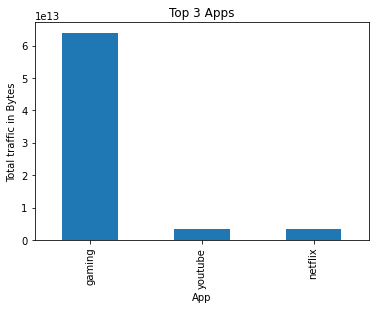

In [75]:
top_3_apps = app_data.sum().nlargest(3)
top_3_apps.plot.bar(title='Top 3 Apps', xlabel='App', ylabel='Total traffic in Bytes')

In [ ]:
Plotter.plot_bar(top_3_apps, 'total_data', 'Top 3 Apps')

Group users in K engagement clusters
The approach followed is refered from [here](https://realpython.com/k-means-clustering-python/)

We're going to use the elbow method to determine the appropriate number of cluster. We're going to run several iterations of K-means and we're going to record the sum of squared errors(SSE)

In [77]:
sse = []
kmeans_kwargs= {
    'init':"k-means++",
    'n_init': 10,
    'max_iter': 300,
    'random_state':20  
}

In [78]:
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(normalized_engagement_metric)
    sse.append(kmeans.inertia_)

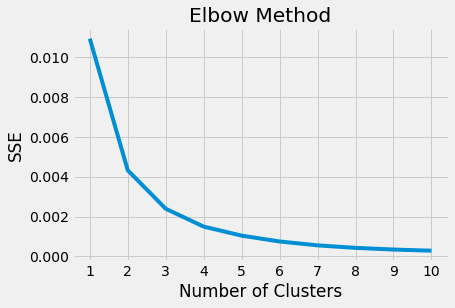

In [79]:
plt.style.use('fivethirtyeight')
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

We can also determine the optimum number of clusters using a package called kneed.

In [81]:
kl = KneeLocator(range(1,11), sse, curve='convex', direction='decreasing')
kl.elbow

3

The elbow method shows us that the sum of the squared errors will decrease the rate of descent after the optimum number of cluster as shown in the plot above.
We have verified that the optimum number of cluster is 3 both graphically and programmatically.